In [1]:
import numpy # matrices and multi - dimensional arrays , linear algebra
import sklearn # machine learning
import matplotlib # plotting

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


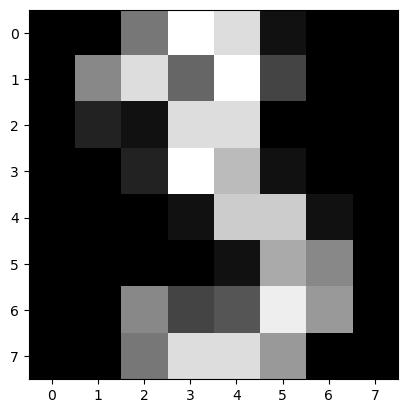

In [3]:
import numpy as np
import matplotlib.pyplot as plt

img = images[3]

assert 2 == len(img.shape)

plt.figure()
plt.gray()
plt.imshow(img,) # also try interpolation =" bicubic "
plt.show()


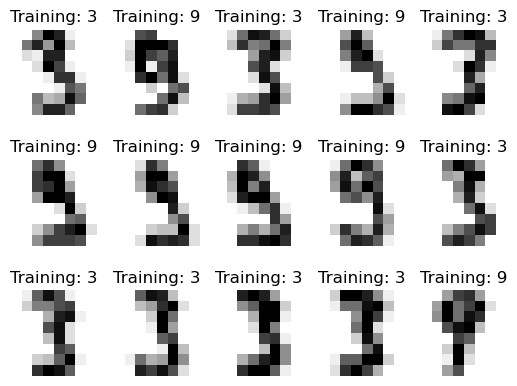

In [4]:
filter_indices = np.where(np.isin(target, [3, 9]))

# Use the filtered indices to get the corresponding elements from data, images, and target
data = data[filter_indices]
images = images[filter_indices]
target = target[filter_indices]
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.axis('off')
    plt.imshow(images[i], cmap=plt.cm.gray_r)
    plt.title('Training: %i' % target[i])

In [5]:
from sklearn import model_selection

X_all = data
y_all = target
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.4, random_state=0)

In [6]:
def features2d(x):
    features = np.zeros((x.shape[0], 2))
    for i in range(x.shape[0]):
        features[i, 0] = x[i, 10] + x[i, 18] + x[i, 26]
        features[i, 1] = x[i, 26] + x[i, 27] + x[i, 28]
       


    return features

all_features = features2d(X_all)
training_features = features2d(X_train)
test_features = features2d(X_test)

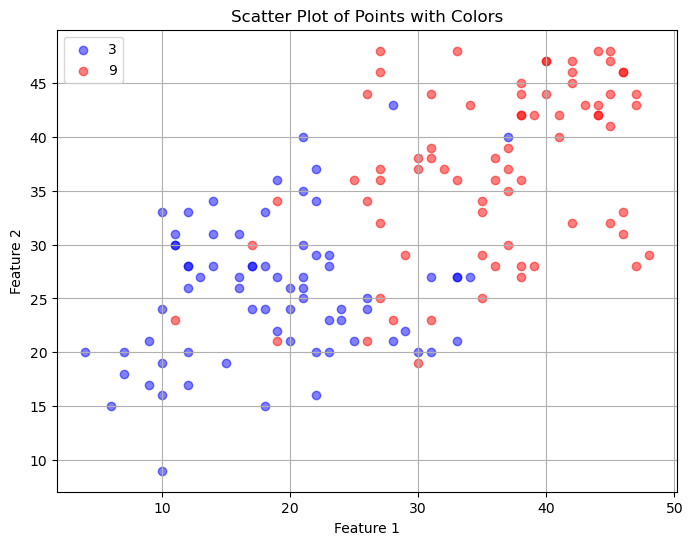

In [7]:
def plot_points_with_colors(points, labels):
    # Extract x and y coordinates
    x_coords = points[:, 0]
    y_coords = points[:, 1]
    
    # Create a mask for points labeled as 3 and 9
    mask_3 = (labels == 3)
    mask_9 = (labels == 9)

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords[mask_3], y_coords[mask_3], marker='o', color='blue', label='3', alpha=0.5)
    plt.scatter(x_coords[mask_9], y_coords[mask_9], marker='o', color='red', label='9', alpha=0.5)
    plt.title('Scatter Plot of Points with Colors')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_points_with_colors(test_features, y_test)

In [8]:
def nearest_mean(training_features, training_labels, test_features):

    #Compute the mean of each class
    mean_3 = np.mean(training_features[training_labels == 3], axis=0)
    mean_9 = np.mean(training_features[training_labels == 9], axis=0)
    
    # Compute the Euclidean distance from each test point to the mean of each class
    distance_3 = np.linalg.norm(test_features - mean_3, axis=1)
    distance_9 = np.linalg.norm(test_features - mean_9, axis=1)
    
    # Classify test points based on the minimum distance
    test_labels = np.where(distance_3 < distance_9, -1, 1)
    
    return test_labels, mean_3, mean_9

def calculate_error_rate(predicted_labels, true_labels):
    total_sample = len(true_labels)
    fn = 0
    fp = 0
    for i in range(total_sample):
        if predicted_labels[i] != -1 and true_labels[i] == 3:
            fn += 1
        elif predicted_labels[i] != 1 and true_labels[i] == 9:
            fp += 1
    
    #print(f"Errors: {fp + fn}/{total_sample} = {(fp + fn) / total_sample:.2f}")
    return (fp + fn) / total_sample  

predicted_labels_mean, mean_3, mean_9 = nearest_mean(training_features, y_train, test_features)
error_rate_mean = calculate_error_rate(predicted_labels_mean, y_test)
print(f"Error Rate Mean: {error_rate_mean*100:.2f}%")


Error Rate Mean: 11.64%


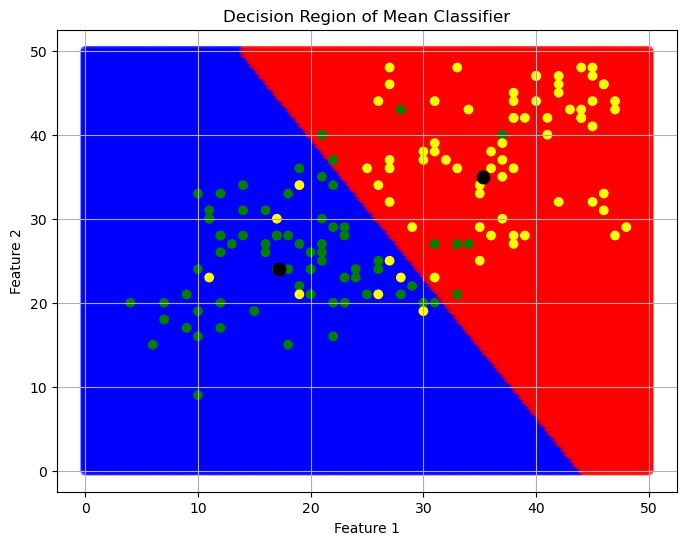

In [10]:
# Create a 200x200 grid
x_min, x_max = 0, 50
y_min, y_max = 0, 50
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

grid_values = np.c_[xx.ravel(), yy.ravel()]

distance_3 = np.linalg.norm(grid_values - mean_3, axis=1)
distance_9 = np.linalg.norm(grid_values - mean_9, axis=1)
    
# Classify test points based on the minimum distance
decision_region = np.where(distance_3 < distance_9, -1, 1)

# Extract x and y coordinates from grid_values
x_coords = grid_values[:, 0]
y_coords = grid_values[:, 1]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=np.where(decision_region == -1, 'blue', 'red'), marker='o', alpha=0.5)
plt.scatter(test_features[:, 0], test_features[:, 1], c=np.where(y_test == 3, 'green', 'yellow'), marker='o', label='Test Data')
plt.scatter([mean_3[0], mean_9[0]], [mean_3[1], mean_9[1]], c='black', marker='o', label='Means', linewidth=4)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Region of Mean Classifier')
plt.grid(True)
plt.show()

In [63]:
def fit_lda(training_features, training_labels):
    # Compute the mean of each class
    mu_3 = np.mean(training_features[training_labels == 3], axis=0)
    mu_9 = np.mean(training_features[training_labels == 9], axis=0)
    mu = np.array([mu_3, mu_9])
    
    # Compute the covariance matrix
    cov = 0
    for x, y in zip(training_features, training_labels):
        if y == 3:
            x_i = x - mu_3
        else:    
            x_i = x - mu_9
        cov += np.outer(x_i, np.transpose(x_i))

    covmat = cov/len(training_labels)
    # Compute the prior probability of each class
    p = np.array([np.sum(training_labels == 3) / len(training_labels), np.sum(training_labels == 9) / len(training_labels)])

    return mu, covmat, p

def filter_pixels(train_data, test_data, var=0.1):
    pixel_variances = np.var(train_data, axis=0)
    # Find pixels with variance smaller than 0.001
    dead_pixels_mask = pixel_variances < var
    # Filter out dead pixels
    filtered_train_data = train_data[:, ~dead_pixels_mask]
    filtered_test_data = test_data[:, ~dead_pixels_mask]
    return filtered_train_data, filtered_test_data

filtered_train_data, filtered_test_data = filter_pixels(X_train, X_test)
feature_mu, feature_covmat, feature_p = fit_lda(training_features, y_train)
var_mu, var_covmat, var_p = fit_lda(filtered_train_data, y_train)
var_covmat_inv = np.linalg.inv(var_covmat)



In [69]:
def predict_lda(mu, covmat, p, test_features):
    # Compute the inverse of the covariance matrix
    covmat_inv = np.linalg.inv(covmat)

    beta = np.dot(covmat_inv, np.transpose(mu[1] - mu[0]))
    b = -0.5 * np.dot((mu[0] + mu[1]), beta) + np.log(p[1] / p[0])
    # Compute decision function scores
    decision_scores = np.dot(test_features, beta) + b
    # Classify test points based on the decision function scores
    predicted_labels = np.sign(decision_scores)
    
    return predicted_labels

predicted_labels_feature = predict_lda(feature_mu, feature_covmat, feature_p, test_features)   
predicted_labels_var = predict_lda(var_mu, var_covmat, var_p, filtered_test_data)

[0.24034121 0.08780151]
-8.948143239056721
0.11643835616438356
[-1.92287832  0.26834423 -0.02796791 -0.13709215 -0.33162341 -0.50889622
  0.01902704  0.37747319 -0.09875159 -0.10095847 -0.56767049  0.23257964
 -0.60649864  0.43321225  0.57070363  0.5704423   1.70890889 -0.61441233
  1.76974069  0.87519109  0.55365709 -0.61538751  1.2994137   1.73126129
  0.9548289  -0.23502472  0.33665359 -0.31673923 -0.27331595 -0.99823462
  0.03850029 -0.25901187 -0.37910078 -1.02146846 -0.74651113 -0.46156741
 -0.1095645  -0.2320828   0.27980268 -0.15020799 -0.2016483  -0.32808154
  1.11749386 -0.16982459  0.09572071  0.15416325 -0.18463906  0.45717297]
-15.742294115012145


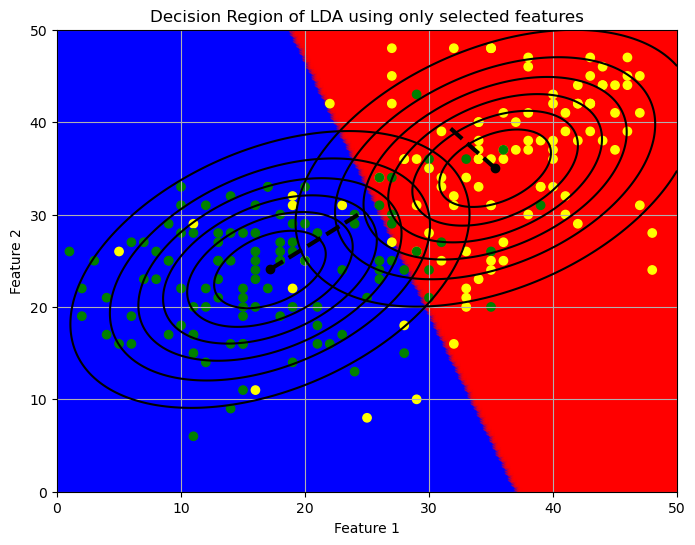

In [65]:
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

# Create a 200x200 grid
x_min, x_max = 0, 50
y_min, y_max = 0, 50
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

grid_values = np.c_[xx.ravel(), yy.ravel()]

# Classify test points based on the decision boundary
decision_region = predict_lda(feature_mu, feature_covmat, feature_p, grid_values)  

# Extract x and y coordinates from grid_values
x_coords = grid_values[:, 0]
y_coords = grid_values[:, 1]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=np.where(decision_region == -1, 'blue', 'red'), marker='o', alpha=0.5)
plt.scatter(training_features[:, 0], training_features[:, 1], c=np.where(y_train == 3, 'green', 'yellow'), marker='o', label='Training Data')
eigenvalues, eigenvectors = np.linalg.eig(feature_covmat)

# Plot each Gaussian distribution
for i in range(len(feature_mu)):
    # Compute PDF values for the grid points
    pdf_values = multivariate_normal.pdf(grid_values, mean=feature_mu[i], cov=feature_covmat)

    # Reshape PDF values to match grid shape
    pdf_values = pdf_values.reshape(xx.shape)

    # Plot isocontours (ellipses)
    plt.contour(xx, yy, pdf_values, colors='k')

    # Plot mean of the Gaussian distribution
    plt.plot(feature_mu[i][0], feature_mu[i][1], 'ko')

    # Compute standard deviations along each principal component (square roots of eigenvalues)
    std_devs = np.sqrt(eigenvalues)

    # Get principal cluster axes (eigenvectors)
    principal_axes = eigenvectors.T[i] * std_devs[i]  # Scale eigenvectors by standard deviations

    # Plot principal cluster axes
    plt.plot([feature_mu[i][0], feature_mu[i][0] + principal_axes[0]], [feature_mu[i][1], feature_mu[i][1] + principal_axes[1]], 'k--', linewidth=3)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Region of LDA using only selected features')
plt.grid(True)
plt.show()

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

estimator = LinearDiscriminantAnalysis()


scores = cross_val_score(estimator, X_all, y_all, cv=10)
print(scores)

[0.97297297 1.         0.97297297 0.94444444 0.97222222 1.
 1.         1.         1.         0.91666667]


As you can see, the results are not that good. Maybe because we used all of the 64 pixels as features instead of selecting meaningful features.

[0.24034121 0.08780151] -8.948143239056721
[-0.0323262  -0.04501887] -0.0019216589861751154
[0.27266741 0.13282038] -8.946221580070546
[0.27266741 0.13282038] -8.946221580070546
[-0.01871928 -0.03016644] -0.001368663594470046
[0.29138668 0.16298682] -8.944852916476076
[0.29138668 0.16298682] -8.944852916476076
[-0.01329805 -0.02260121] -0.0010783410138248848
[0.30468473 0.18558803] -8.943774575462252
[0.30468473 0.18558803] -8.943774575462252
[-0.00932898 -0.01849296] -0.000870967741935484
[0.31401371 0.204081  ] -8.942903607720316
[0.31401371 0.204081  ] -8.942903607720316
[-0.00733726 -0.01441277] -0.0007188940092165899
[0.32135097 0.21849377] -8.9421847137111
[0.32135097 0.21849377] -8.9421847137111
[-0.00587109 -0.0117293 ] -0.0006082949308755761
[0.32722207 0.23022307] -8.941576418780224
[0.32722207 0.23022307] -8.941576418780224
[-0.00488894 -0.01027652] -0.0005391705069124424
[0.332111   0.24049959] -8.941037248273311
[0.332111   0.24049959] -8.941037248273311
[-0.00454283 -0.00

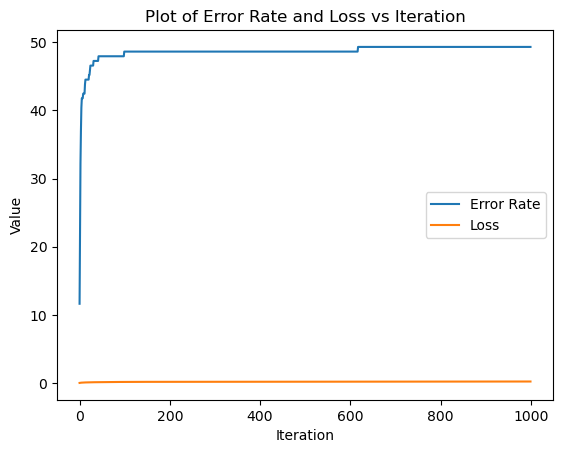

In [80]:
def calculate_delta_loss(X, y, beta, b, _lambda):
    sum_b = 0
    sum_beta = 0
    for i in range(len(y)):
            if y[i] * (np.dot(X[i], beta) + b) < 1:
                sum_beta -= y[i] * np.transpose(X[i])
                sum_b -= y[i]
    delta_b = (_lambda / len(y)) * sum_b
    delta_beta = beta + (_lambda / len(y)) * sum_beta

    return delta_beta, delta_b

def fit_svm(training_features, training_labels, _lambda, beta, b, tau):
    _sum = 0
    for i in range(len(training_labels)):
        _sum += np.maximum(1 - training_labels[i] * (np.dot(training_features[i], beta)) + b, 0)

    loss = 0.5 * np.dot(np.transpose(beta), beta) + (_lambda / len(training_labels)) * _sum

    delta_beta, delta_b = calculate_delta_loss(training_features, training_labels, beta, b, _lambda)
    print(beta, b)
    print(tau * delta_beta, tau * delta_b)
    beta -= tau * delta_beta
    b -= tau * delta_b
    print(beta, b)

    return loss, beta, b

def predict_svm(test_features, beta, b):
    return np.sign(np.dot(test_features, beta) + b)


tau = 0.0001
_lambda = 10
#beta = np.random.normal(0, 1, training_features.shape[1])
#b = 0
beta = np.array([0.24034121, 0.08780151])
b = -8.948143239056721

epochs = 1000
error_rate_list = []
loss_list = []

for i in range(epochs):
    if i == 900:
        tau /= 10
    predicted_labels = predict_svm(test_features, beta, b)
    error_rate = calculate_error_rate(predicted_labels, y_test)
    loss, beta, b = fit_svm(training_features, y_train, _lambda, beta, b, tau)
    error_rate_list.append(error_rate*100)
    loss_list.append(loss)

plt.plot(range(epochs), error_rate_list, label='Error Rate')
plt.plot(range(epochs), loss_list, label='Loss')

plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Plot of Error Rate and Loss vs Iteration')
plt.legend()
plt.show()

